# Task specific functions

The classes and functions in this notebook are highly specific and probably not usefull for the most tasks.


In [1]:
# export
# default_exp utils

from fastai.basics import *
import pathlib
import SimpleITK as sitk

In [2]:
# export

from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.data import *
from faimed3d.models import *

## Flipping NIfTI images
When displaying the masks it may occure, that Nifti images are rotated and do not fit the original DICOM. Most likely it is due to different frames of reference. 
in Simple-ITK it is LPS, while NIfTI and FSL use RAS, so those matrices are the same after accounting for frame of reference (taken and adapted from https://discourse.itk.org/t/nifti-orientation-issues/431).
So, luckly the malrotations are systematic and can be scripted.

In [3]:
# export utils
class RotateNifti():
    def __init__(self):
        warn('This class will change the source files on you disk. Be carefull.')
    
    def rotate_single(self, fn:(Path, str)):
        if isinstance(fn, Path): fn = str(fn) 
        
        im = sitk.ReadImage(fn)
        arr = sitk.GetArrayFromImage(im)
        arr = np.rot90(arr, 0)
        arr = np.flip(arr, 1)
        im2 = sitk.GetImageFromArray(arr)
        for k in im.GetMetaDataKeys(): # Copy meta data from original image before overwriting it. 
            im2.SetMetaData(k, im.GetMetaData(k))
        sitk.WriteImage(im2, fn)
   
    def rotate_list(self, file_list=None, verbose = True):
        if file_list is not None: self.file_list = file_list
    
        for fn in file_list: 
            self.rotate_single(fn)
            if verbose: print('converted file at: '+str(fn))

## Exporting subvolumes

In processing medical 3D data, a challenge is to that the regions of interest are often very small. For example, if the goal is to segment and classify kideny cancer from abdominal CT scans, the cancer corresponds to less then 1% of the voxels in the volume. The most voxels are not relevant for the task. One possibility to deal with this problem, is to first train a model which segments the whole kidney and to only export this subvolume. Then a second model can be trained on the subvolumes. 


At first a learner must be created, so that predictions can be made

In [4]:
# set path to data
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')
# load only original images
train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))
files = train_files + valid_files

# only T2
subset_files =[]
for f in files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_files.append(Path(m.string))

# get masks
segmentation_files = [(p.parent/'Annotation').ls()[0] for p in subset_files]

# design dataloader
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              MaskBlock3D(codes = ['void', "peripheral", 'transitional', 'cancer'])),
    get_x = lambda x: x[0],
    get_y = lambda x: x[1], 
    item_tfms = ResizeCrop3D(crop_by = (0.2, 0.15, 0.15), resize_to = (16, 100, 100), perc_crop = True),
    batch_tfms = [
        *aug_transforms_3d(p_all=0.25, do_rotate_by = False), 
        RandomCrop3D(((0, 0), (0,0), (0,0)), (0, 0, 0)), 
        ClampMask3D,
        PseudoColor],
    splitter = RandomSplitter())

# construct dataloader
d = pd.DataFrame({'image' : subset_files, 
                  'mask' : segmentation_files})

dls = mris.dataloaders(d, 
                       batch_size = 10, 
                       num_workers = 0,
                      )

# creater learner
mcc_loss = MCCLossBinary()

learn = Learner(dls, 
                UNet3D(n_channels = 1, n_classes = 2),
                opt_func = SGD, 
                loss_func = MCCLossBinary(), 
                model_dir = '../pretrained/',
               )
learn = learn.to_fp16()
learn = learn.load('unet-whole-prostate-20x100x100')

To convieniently perform predictions, cropping and exporting a `SubvolumeExporter` class is created.

In [5]:
# export
class SubvolumeExporter(object):
    def __init__(self):
        self.model = None
        self.item_tfms = None
    
    def assign_model(self, model):
        self.model = model
        
    def assign_tfms(self, tfms):
        "assign transformations which should be applied to the surce, before size of source and mask are matched"
        self.item_tfms = tfms
    
    def merge_mask(self, mask):
        mask = mask.squeeze()
        if mask.ndim == 4:
            mult_channel_by = tensor(range(0, mask.size(0)))
            mask = mask * mult_channel_by[:, None, None, None]
            return torch.sum(mask, 0)  
        else: return mask
        
    def match_size_mask_source(self):
        "rescales the segmentation mask to the original image resolution"

        if self.item_tfms == None: raise TypeError('No item_tfms specified.')
        source = TensorDicom3D.create(self.item_path)
        self.metadata = source.metadata
        source = self.item_tfms(source) # will lose metadata in transforms
        
        x,y = source.size()[1:]
        z = self.mask.size(0)
        source = source.resize_3d(size = (z,x,y), mode = 'trilinear')
        self.mask = self.mask.resize_3d(size = source.size(), mode = 'nearest')
        self.mask = TensorMask3D(self.mask)
        self.orig = TensorMask3D(source)
        self.mask.metadata = self.metadata
        self.orig.metadata = self.metadata

    
    def predict(self, item, rm_type_tfms=None):
        self.item_path = item
        _, self.mask, _ = self.model.predict(self.item_path, rm_type_tfms)
        self.mask = self.mask.round()
        self.mask = self.merge_mask(self.mask)
        self.mask = TensorMask3D(self.mask)

        self.match_size_mask_source()
    
    def show_pair(self, alpha = 0.25, **kwargs):
        self.orig.show(**kwargs)
        self.mask.show(add_to_existing = True, alpha = alpha, cmap = 'jet', **kwargs)
        
    def strip_pair(self, pad_z = 1, pad_xy = 5):
        "padds the idexes, so that a small margin of zeros remains"

        self.orig.strip_idx = self.mask.get_strip_idx(symmetric=True)
        self.mask = self.mask.strip(pad_z = pad_z, pad_xy=pad_xy)
        self.orig = self.orig.strip(pad_z = pad_z, pad_xy=pad_xy)
        self.orig.metadata = self.metadata
        self.mask.metadata = self.metadata
        
    def convert_and_export(self, source, orig_name, mask_name, pad_z, pad_xy, verbose):
        """
        Reads a list of source images and uses a given learner to predict the mask. Crops the mask and source image an then exports the files. 
        
        Args: 
            source: str or path. The path to the original image. Can be a DICOM direcetory or a single DICOM, NIfTI, NRRD, Analyze file (any type supported by SimpleITK) 
            orig_name: str or path. New filename for the cropped original image
            mask_name: str or path. New filename for the predicted mask.
            
        returns: 
            Nothing. Writes files to disk.
        """
        if self.model is None: raise NameError('No model for predictions assigned. Assing a model to the {} using {}.assign_model(model)'.format(self.__class__.__name__, self.__class__.__name__))
        
        self.predict(source)
        self.strip_pair(pad_z = pad_z, pad_xy = pad_xy)
        self.orig.save(orig_name)
        self.mask.save(mask_name)
        
        if verbose: print('wrote image to {} and mask to {}'.format(str(orig_name), str(mask_name)))
            
    def convert_and_export_list(self, source, orig_name, mask_name, pad_z = 1, pad_xy = 5, verbose = True):
        if not isinstance(source, list) or not isinstance(orig_name, list) or not isinstance(mask_name, list): raise TypeError('source, orig_name, mask_name need to be lists of equal size')
        if len(source) != len(orig_name) or len(source) != len(mask_name): raise TypeError('source, orig_name, mask_name need to be lists of equal size')
                     
        for s, o, m, in zip(source, orig_name, mask_name): 
            self.convert_and_export(s, o, m, pad_z, pad_xy, verbose)            

A model needs to be assigned to the SubvolumeExporter, so predictions on new data can be made. 

In [30]:
SubvolumeExport = SubvolumeExporter() 
SubvolumeExport.assign_model(learn)
SubvolumeExport.assign_tfms(RandomCrop3D(crop_by = (0.2, 0.15, 0.15), rand_crop_xyz = (0,0,0), perc_crop = True))
SubvolumeExport.predict(subset_files[0]) # predict mask on one image

/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


To check the quality of the class and predictions, botch can be visualized.  

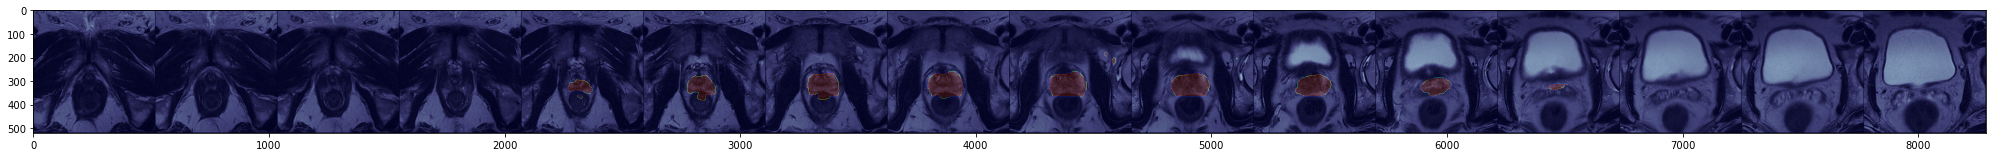

In [31]:
SubvolumeExport.show_pair(nrow = 16, figsize = (35, 25))

Using strip_paor reduces the image size, so that it narrowly fits the mask. 
Per default padding will be 0 so the largest mask diameter will decide on the size of the image. Using pad_z, pad_x, pad_y (or pad_xy instead of pad_x, pad_y) a small marign can be added in case the classes do not fit perfectly. Padding image size larger then original size is not possible and will not lead to black spaces.  

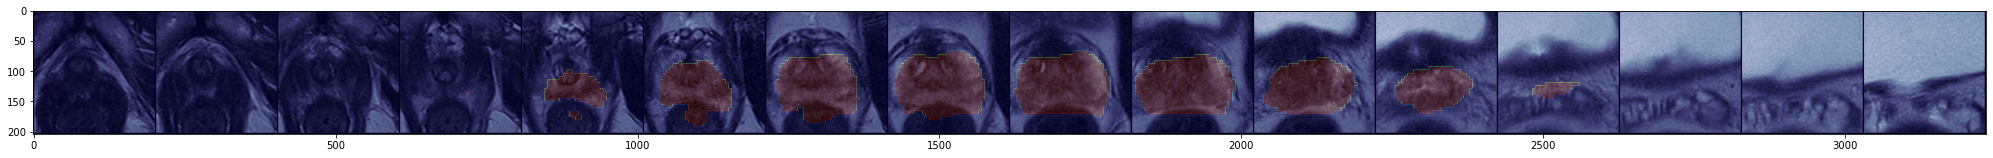

In [32]:
SubvolumeExport.strip_pair(pad_xy = 5, pad_z = 10)
SubvolumeExport.show_pair(nrow = 16, figsize = (35, 25))

In [33]:
SubvolumeExport.mask.calc_volume()

{'background': 122746.9375, 'total_mask_volume': 19029.759048613778, 'class 1': 19029.755859375}


In [34]:
cropped_original = [p/'cropped_volume.nii.gz' for p in subset_files]
cropped_mask = [p.parent/'Annotation/predicted_mask.nii.gz' for p in subset_files]

The above steps are all executed using convert_and_export. Additionally the images are written to disk. 

In [40]:
i = 15
SubvolumeExport.convert_and_export(subset_files[i], cropped_original[i], cropped_mask[i], pad_z = 10, pad_xy = 10, verbose = True)

wrote image to ../../dl-prostate-mapping/data/train/Gesund/A0040687294/T2/DICOM/cropped_volume.nii.gz and mask to ../../dl-prostate-mapping/data/train/Gesund/A0040687294/T2/Annotation/predicted_mask.nii.gz


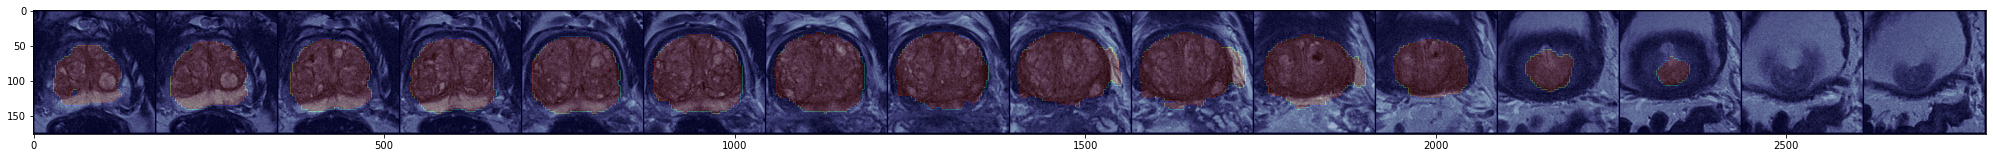

In [41]:
TensorDicom3D.create(cropped_original[i]).show(nrow = 16, figsize = (35, 25))
TensorDicom3D.create(cropped_mask[i]).show(add_to_existing = True, alpha = 0.25, cmap = 'jet', nrow = 16, figsize = (35, 25))

When converting multipl images, convert_and_export_list can be used. 

## Reduce size of original image and mask

The predicted mask and theroff derived images can be used for segementation pipelines, however the mask shows only as much imformation as the model did predict. To further train the images, it makes no sense exporting the predicted mask, but the original mask and images need to be cropped and exported. A subclass of `SubvolumeExporter` can convert the original files, but the export functions need to be adapted.  

In [6]:
class CropOriginalToMask(SubvolumeExporter):
    
    def load_pair(self, image, mask):
        self.orig = TensorMask3D.create(image)
        self.mask = TensorMask3D.create(mask)
        self.metadata = self.orig.metadata
        self.mask.metadata = self.metadata
        
    def export_pair(self, new_image, new_mask, pad_z, pad_xy):
        self.strip_pair(pad_z = pad_z, pad_xy = pad_xy)
        self.orig.save(new_image)
        self.mask.save(new_mask)
        
    def convert_and_export(self, image, mask, new_image=None, new_mask=None, pad_z=1, pad_xy=10, verbose = True):
        if isinstance(image, str): image = Path(image)
        if isinstance(mask, str): mask = Path(mask)
                
        if new_image is None: 
            if image.is_dir(): 
                new_image = image/'cropped_volume.nii.gz'
            else: 
                new_image = image.parent/'cropped_volume.nii.gz'
                
                
        if new_mask is None: 
            if mask.is_dir(): 
                new_mask = mask/'cropped_mask.nii.gz'
            else:     
                new_mask = mask.parent/'cropped_mask.nii.gz'
          
        self.load_pair(image, mask)
        self.export_pair(new_image, new_mask, pad_z, pad_xy)
               
        if verbose: print('wrote image to {} and mask to {}'.format(str(new_image), str(new_mask)))
            
    def convert_and_export_list(self, image, mask, new_image=None, new_mask=None,  pad_z = 1, pad_xy = 10, verbose = True):
        if not isinstance(image, list) or not isinstance(mask, list): raise TypeError('source, orig_name, mask_name need to be lists of equal size')
         
        if len(image) != len(mask): raise TypeError('source, orig_name, mask_name need to be lists of equal size')
                     
        for i, m in zip(image, mask): 
            self.convert_and_export(image=i, mask=m, new_image=new_image, new_mask=new_mask, pad_z=pad_z, pad_xy=pad_xy, verbose=verbose)    

In [7]:
Crop = CropOriginalToMask()
Crop.convert_and_export(subset_files[0], segmentation_files[0])

wrote image to ../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM/cropped_volume.nii.gz and mask to ../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/Annotation/cropped_mask.nii.gz


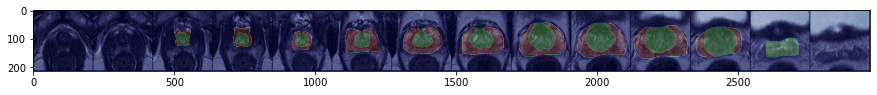

In [8]:
TensorDicom3D.create('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM/cropped_volume.nii.gz').show(nrow = 14)
TensorMask3D.create('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/Annotation/cropped_mask.nii.gz').show(nrow = 14, add_to_existing = True, cmap = 'jet', alpha = 0.25)

In [9]:
Crop.convert_and_export_list(subset_files, segmentation_files, pad_z = 1, pad_xy = 10)

wrote image to ../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM/cropped_volume.nii.gz and mask to ../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/Annotation/cropped_mask.nii.gz
wrote image to ../../dl-prostate-mapping/data/train/Gesund/A0042234258/T2/DICOM/cropped_volume.nii.gz and mask to ../../dl-prostate-mapping/data/train/Gesund/A0042234258/T2/Annotation/cropped_mask.nii.gz
wrote image to ../../dl-prostate-mapping/data/train/Gesund/A0041881589/T2/DICOM/cropped_volume.nii.gz and mask to ../../dl-prostate-mapping/data/train/Gesund/A0041881589/T2/Annotation/cropped_mask.nii.gz
wrote image to ../../dl-prostate-mapping/data/train/Gesund/A0040094374/T2/DICOM/cropped_volume.nii.gz and mask to ../../dl-prostate-mapping/data/train/Gesund/A0040094374/T2/Annotation/cropped_mask.nii.gz
wrote image to ../../dl-prostate-mapping/data/train/Gesund/A0041994086/T2/DICOM/cropped_volume.nii.gz and mask to ../../dl-prostate-mapping/data/train/Gesund/A0041994086/T2/Annotation/

## DWI handler

DWI sequences contain multiple b-values. The higest b-value is usually to only one is interested in. 
ADC is calculated from DWI, so number of slices in  dwi sould be multiple of ADC. 

In [7]:
# set path to data
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')
# load only original images
train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))
files = train_files + valid_files 

# only T2
dwi_files, adc_files, t2_files=[], [], []
for f in files: 
    m = re.search(r'ADC|DWI|T2', str(f)) 
    if hasattr(m, 'string'): 
        if 'DWI' in m.string: dwi_files.append(Path(m.string))
        if 'ADC' in m.string: adc_files.append(Path(m.string))
        if 'T2' in m.string: t2_files.append(Path(m.string))

# get masks
segmentation_files = [(p.parent/'Annotation').ls()[0] for p in adc_files]

In [8]:
dwi_sample = TensorDicom3D.create(dwi_files[0])
adc_sample = TensorDicom3D.create(adc_files[0])

In [9]:
def get_highest_bvalue(dwi_path, adc_path):
    dwi = TensorDicom3D.create(dwi_path)
    adc = TensorDicom3D.create(adc_path)

    metadata = dwi.metadata
    start = dwi.size(0)-adc.size(0)
    end = dwi.size(0)
    dwi = dwi[0:adc.size(0), ]
    
    # dwi sequence can be invertd
    _, _, x = metadata['origin']
    _,_ , y = adc.metadata['origin']
    
    if abs(x - y) > (x - -y):
        dwi = dwi.flip(0)
    
    dwi = TensorDicom3D(dwi)
    dwi.metadata = metadata
    return dwi

In [21]:
im = get_highest_bvalue('../../dl-prostate-mapping/data/valid/ProstataCa/A0001229569/DWI/DICOM', '../../dl-prostate-mapping/data/valid/ProstataCa/A0001229569/ADC/DICOM')
im.save('../../dl-prostate-mapping/data/valid/ProstataCa/A0001229569/DWI/DICOM'+'/highest_b.nii')

Exception in callback BaseAsyncIOLoop._handle_events(24, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(24, 1)>
Traceback (most recent call last):
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 139, in _handle_events
    handler_func(fileobj, events)
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 462, in _handle_events
    self._handle_recv()
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 492, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 444, in _run_callback
    callback(*args, **kwargs)
  File "/home/bressekk/anaconda3/envs/fastai

In [18]:
!ls ../../dl-prostate-mapping/data/valid/ProstataCa/A0001229569/DWI/DICOM

0001.dcm  0015.dcm  0029.dcm  0043.dcm	0057.dcm  0071.dcm  0085.dcm
0002.dcm  0016.dcm  0030.dcm  0044.dcm	0058.dcm  0072.dcm  0086.dcm
0003.dcm  0017.dcm  0031.dcm  0045.dcm	0059.dcm  0073.dcm  0087.dcm
0004.dcm  0018.dcm  0032.dcm  0046.dcm	0060.dcm  0074.dcm  0088.dcm
0005.dcm  0019.dcm  0033.dcm  0047.dcm	0061.dcm  0075.dcm  0089.dcm
0006.dcm  0020.dcm  0034.dcm  0048.dcm	0062.dcm  0076.dcm  0090.dcm
0007.dcm  0021.dcm  0035.dcm  0049.dcm	0063.dcm  0077.dcm  0091.dcm
0008.dcm  0022.dcm  0036.dcm  0050.dcm	0064.dcm  0078.dcm  0092.dcm
0009.dcm  0023.dcm  0037.dcm  0051.dcm	0065.dcm  0079.dcm  0093.dcm
0010.dcm  0024.dcm  0038.dcm  0052.dcm	0066.dcm  0080.dcm  0094.dcm
0011.dcm  0025.dcm  0039.dcm  0053.dcm	0067.dcm  0081.dcm  0095.dcm
0012.dcm  0026.dcm  0040.dcm  0054.dcm	0068.dcm  0082.dcm  0096.dcm
0013.dcm  0027.dcm  0041.dcm  0055.dcm	0069.dcm  0083.dcm  highest_b.nii
0014.dcm  0028.dcm  0042.dcm  0056.dcm	0070.dcm  0084.dcm


In [17]:
for dwi, adc in list(zip(dwi_files, adc_files)): 
    print('wrote '+str(dwi))
    im = get_highest_bvalue(dwi, adc)
    im.save(str(dwi) + '/highest_b.nii')


wrote ../../dl-prostate-mapping/data/train/Gesund/A0042197734/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0042234258/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0040702076/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0040725762/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0071305713/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0041888884/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0041610536/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0040967467/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0041286555/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0040013257/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0041836729/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0042096725/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0040513172/DWI/DICOM
wrote ../../dl-prostate-mapping/data/train/Gesund/A0042280702/DW

Exception in callback BaseAsyncIOLoop._handle_events(24, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(24, 1)>
Traceback (most recent call last):
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 139, in _handle_events
    handler_func(fileobj, events)
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 462, in _handle_events
    self._handle_recv()
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 492, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 444, in _run_callback
    callback(*args, **kwargs)
  File "/home/bressekk/anaconda3/envs/fastai

In [74]:
def compare_tags(p_dcm1, p_dcm2, tag):
    dcm1 = TensorDicom3D.create(p_dcm1)
    dcm2 = TensorDicom3D.create(p_dcm2)
    
    m1 = dcm1.metadata['table']
    m2 = dcm2.metadata['table']
    
    tag1 = m1.loc[m1.tags ==  tag]
    tag2 = m2.loc[m2.tags ==  tag]
    
    if tag1.iloc[0,1] != tag2.iloc[0,1]:
        
        print(str(p_dcm1) + ': ' + tag1.iloc[0,1], '\n',
              str(p_dcm2) + ': ' + tag2.iloc[0,1] , '\n'
             )
    
    return tag1.iloc[0,1] == tag2.iloc[0,1]


In [75]:
compare_tags(adc_files[0], dwi_files[0], '0008|0050')

True